# CHAOS 6 model evaluation

In [1]:
# generate grid

from numpy import empty, linspace, meshgrid, stack

nlats = 180
nlons = 360

_lats = linspace(-90, 90, nlats + 1)
_lons = linspace(-180, 180, nlons + 1)

coords = empty((_lats.size, _lons.size, 3))

coords[:,:,1], coords[:,:,0] = meshgrid(_lons, _lats)
coords[:,:,2] = 0 # height above WGS84 in km

del _lons, _lats

In [2]:
# load and evaluate model
from datetime import datetime
from eoxmagmod.data import CHAOS6_CORE_LATEST
from eoxmagmod import (
    load_model_shc, decimal_year_to_mjd2000, vincdecnorm,
    convert, GEODETIC_ABOVE_WGS84,
)
from eoxmagmod.util import datetime_to_decimal_year

timestamp = datetime(2019, 1, 1)
epoch = datetime_to_decimal_year(timestamp)
mjd2000 = decimal_year_to_mjd2000(epoch)

print(timestamp, epoch, mjd2000)

model = load_model_shc(CHAOS6_CORE_LATEST)

b_neu = model.eval(mjd2000, coords, GEODETIC_ABOVE_WGS84, GEODETIC_ABOVE_WGS84) # B in Noorth, East, Up coordinate frame

inclination, declination, intensity = vincdecnorm(b_neu)


2019-01-01 00:00:00 2019.0 6940.0


In [3]:
from numpy import isnan, logical_and, abs as aabs, cumsum, stack, pi
from matplotlib.pyplot import figure, subplot, show, suptitle
from scipy.interpolate import interp1d
from cartopy.feature import LAND, OCEAN, COASTLINE
from cartopy.crs import Mollweide, Orthographic, PlateCarree
%matplotlib inline


def _plot_contours(ax, x, y, z, *args, **kwargs):
    transform_before_plotting = kwargs.pop("transform_before_plotting", False)
    if transform_before_plotting:
        # transform coordinates *before* passing them to the plotting function
        tmp = ax.projection.transform_points(PlateCarree(), x, y)
        x_t, y_t = tmp[..., 0], tmp[..., 1]
        return ax.contour(x_t, y_t, z, *args, **kwargs)
    else:
        # ... transformation performed by the plotting function creates glitches at the antemeridian
        kwargs["transform"] = PlateCarree()
        return ax.contour(x, y, z, *args, **kwargs)


def plot_contours(ax, x, y, z, *args, **kwargs):
    fmt = kwargs.pop("fmt", "%g")
    fontsize = kwargs.pop("fontsize", 6)
    ax.add_feature(LAND, facecolor=(1.0, 1.0, 0.9))
    ax.add_feature(OCEAN, facecolor=(0.9, 1.0, 1.0))
    ax.add_feature(COASTLINE, edgecolor='silver')
    cs = _plot_contours(ax, x, y, z, *args, **kwargs)
    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=fontsize)
    

# Notes:
#  - the polar orthographic projection works only with all points
#    within the maps extent (i.e., visible part of the globe).
#  - if you see an 


north = (coords[:, 0, 0] > 0).nonzero()[0]
south = (coords[:, 0, 0] < 0).nonzero()[0]

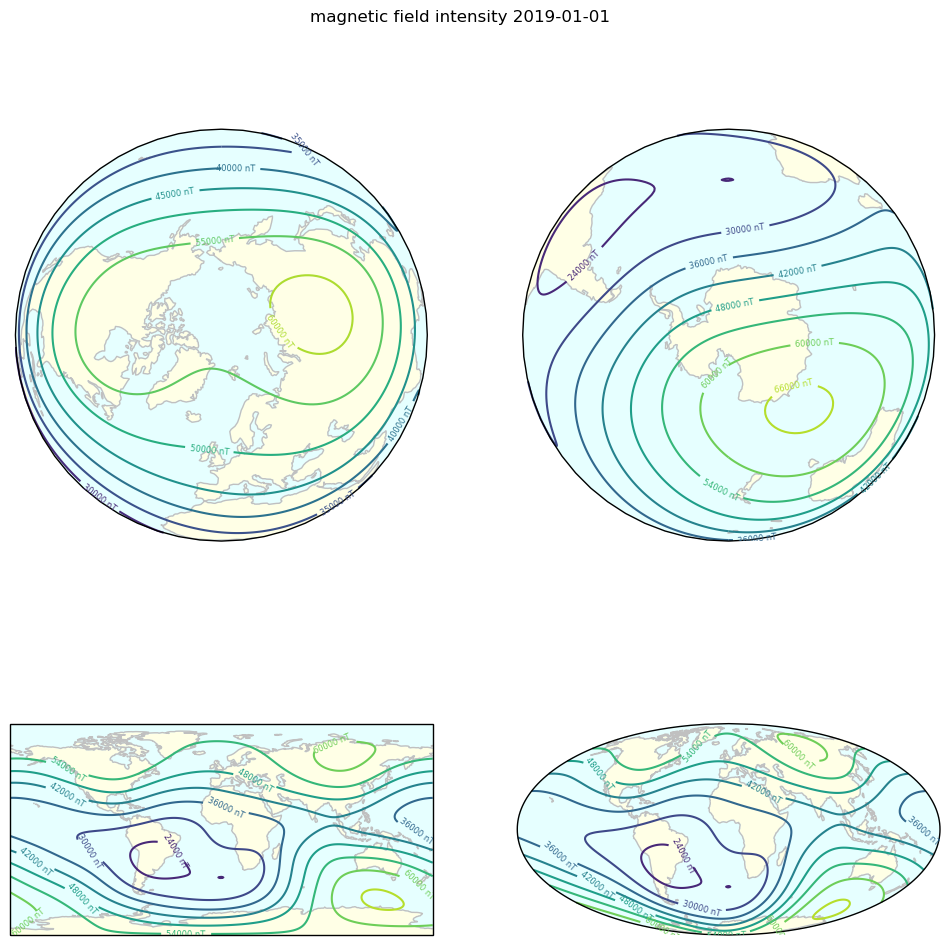

In [4]:
data = intensity
options = {
    "fmt": "%g nT" 
}

fig = figure(figsize=(12, 12), dpi=100)
suptitle("magnetic field intensity %s" % timestamp.date())
ax = subplot(2, 2, 1, projection=Orthographic(0, 90))
plot_contours(ax, coords[north, :, 1], coords[north, :, 0], data[north, :], transform_before_plotting=True, **options)
ax = subplot(2, 2, 2, projection=Orthographic(0, -90))
plot_contours(ax, coords[south, :, 1], coords[south, :, 0], data[south, :], transform_before_plotting=True, **options)
ax = subplot(2, 2, 3, projection=PlateCarree())
plot_contours(ax, coords[..., 1], coords[..., 0], data, **options)
ax = subplot(2, 2, 4, projection=Mollweide())
plot_contours(ax, coords[..., 1], coords[..., 0], data, transform_before_plotting=False, **options)

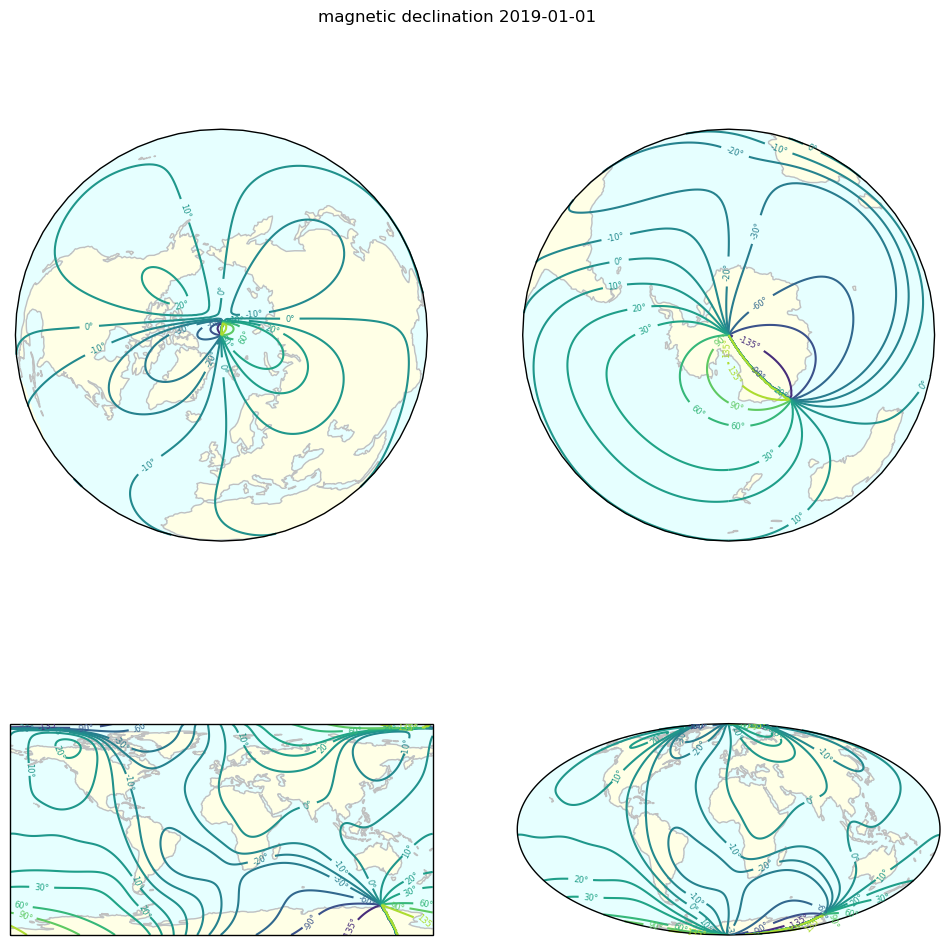

In [5]:
data = declination
options = {
    "levels": [-180, -135, -90, -60, -30, -20, -10, 0, 10, 20, 30, 60, 90, 135, 180],
    "fmt": "%g°"
}
fig = figure(figsize=(12, 12), dpi=100)
suptitle("magnetic declination %s " % timestamp.date())
ax = subplot(2, 2, 1, projection=Orthographic(0, 90))
plot_contours(ax, coords[north, :, 1], coords[north, :, 0], data[north, :], transform_before_plotting=True, **options)
ax = subplot(2, 2, 2, projection=Orthographic(0, -90))
plot_contours(ax, coords[south, :, 1], coords[south, :, 0], data[south, :], transform_before_plotting=True, **options)
ax = subplot(2, 2, 3, projection=PlateCarree())
plot_contours(ax, coords[..., 1], coords[..., 0], data, **options)
ax = subplot(2, 2, 4, projection=Mollweide())
plot_contours(ax, coords[..., 1], coords[..., 0], data, transform_before_plotting=False, **options)


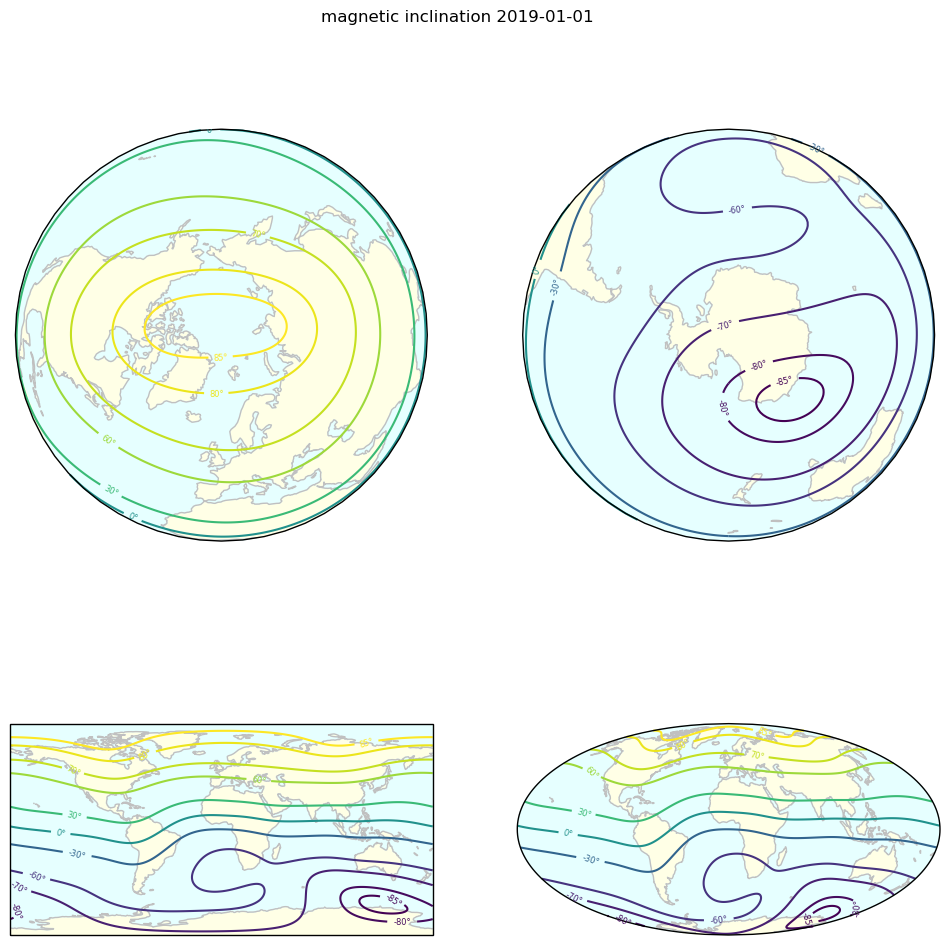

In [6]:
data = inclination
options = {
    "levels": [-85, -80, -70, -60, -30, 0, 30, 60, 70, 80, 85],
    "fmt": "%g°"
}
fig = figure(figsize=(12, 12), dpi=100)
suptitle("magnetic inclination %s " % timestamp.date())
ax = subplot(2, 2, 1, projection=Orthographic(0, 90))
plot_contours(ax, coords[north, :, 1], coords[north, :, 0], data[north, :], transform_before_plotting=True, **options)
ax = subplot(2, 2, 2, projection=Orthographic(0, -90))
plot_contours(ax, coords[south, :, 1], coords[south, :, 0], data[south, :], transform_before_plotting=True, **options)
ax = subplot(2, 2, 3, projection=PlateCarree())
plot_contours(ax, coords[..., 1], coords[..., 0], data, **options)
ax = subplot(2, 2, 4, projection=Mollweide())
plot_contours(ax, coords[..., 1], coords[..., 0], data, transform_before_plotting=False, **options)